In [2]:
# SN TNS name
tnsname = '2023ixf'

# SN discovery date
discovery_date = 60063.727257 + 50

# path to directory that contains SN and control light curves
source_dir = '/Users/svoncoelln/Documents/swp/2023ixf'

# number of control light curves to load
n_controls = 16

# filter of light curve to analyze
filt = 'o'

# MJD bin size in days of light curve to analyze
mjd_bin_size = 1.0

# define flags that define bad measurements (to filter out bad days in lc)
flags = 0x800000

In [3]:
import pandas as pd
import numpy as np
import sys,copy,random,math
import scipy.stats as stats
from pdastro import pdastrostatsclass, AandB, AnotB, AorB
from asym_gaussian import gauss2lc

# plotting
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

# plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend', fontsize = 12)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
#plt.rc('text', usetex=True)

# for storing lc and control lcs 
global lcs
lcs = {}

# for storing info about the lc
global lc_info
lc_info = {}

# convert flux to magnitude 
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 23.9

# convert magnitude to flux
def mag2flux(mag):
    return 10 ** ((mag - 23.9) / -2.5)

def load_lc(source_dir, tnsname):
	lcs[0] = pdastrostatsclass()
	filename = f'{source_dir}/{lc_info["tnsname"]}.{lc_info["filt"]}.{lc_info["mjd_bin_size"]:0.2f}days.lc.txt'
	print(f'Loading light curve for SN {tnsname} at {filename}...')
	try:
		lcs[0].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('ERROR: Could not load light curve at %s: %s' % (filename, str(e)))
		sys.exit()
	
	lc_info['baseline_ix'] = lcs[0].ix_inrange(colnames=['MJDbin'], uplim=lc_info['discovery_date']-20, exclude_uplim=True)
	if len(lc_info['baseline_ix'])<=0:
		print('Baseline length is 0! Exiting...')
		sys.exit()
	lc_info['afterdiscdate_ix'] = AnotB(lcs[0].getindices(), lc_info['baseline_ix']) 

def load_control_lcs(source_dir, tnsname, n_controls): 
	print(f'Loading control light curves for SN {tnsname}...')
	for control_index in range(1, n_controls+1):
		lcs[control_index] = pdastrostatsclass()
		filename = f'{source_dir}/controls/{lc_info["tnsname"]}_i{control_index:03d}.{lc_info["filt"]}.{lc_info["mjd_bin_size"]:0.2f}days.lc.txt'
		print(f'# Loading control light curve {control_index:03d} at {filename}...')
		try:
			lcs[control_index].load_spacesep(filename,delim_whitespace=True)
		except Exception as e:
			print(f'ERROR: Could not load control light curve {control_index:03d} at {filename}: {str(e)}')
			sys.exit()

def load_lcs(source_dir, tnsname, n_controls):
    load_lc(source_dir, tnsname)
    load_control_lcs(source_dir, tnsname, n_controls)

def load_detected(source_dir, gauss_sigmas, peaks, detected=None):
    detected = {}
    for gauss_sigma in gauss_sigmas:
        for peak in peaks:
            filename = f'{source_dir}/bump_analysis/tables2/detected_{gauss_sigma}_{peak:0.2f}.txt'
            detected[f'{gauss_sigma}_{peak:0.2f}'] = pdastrostatsclass()
            detected[f'{gauss_sigma}_{peak:0.2f}'].load_spacesep(filename=filename, delim_whitespace=True)
    return detected

def load_detected_per_peak(source_dir, detected_per_peak=None):
    filename = f'{source_dir}/bump_analysis/tables2/detected_per_peak.txt'
    detected_per_peak = pdastrostatsclass()
    detected_per_peak.load_spacesep(filename=filename, delim_whitespace=True)
    return detected_per_peak

def apply_gaussian(lc, gaussian_sigma, sim_gauss=False, sim_peakmjd=None, sim_appmag=None, sim_sigma=None, print_=True, flag=0x800000):
    if len(lc_info['baseline_ix']) <= 0:
        print('ERROR: Not enough data in baseline flux (before SN start)!')

    ix = lc_info['baseline_ix'] # all pre-SN indices
    good_ix = AandB(ix, lc.ix_unmasked('Mask', flag)) # all good pre-SN indices

    # make sure there are no lingering simulations
    dropcols=[]
    for col in ['uJysim','SNRsim','simLC','SNRsimsum']:
        if col in lc.t.columns:
            dropcols.append(col)
    if len(dropcols) > 0:
        lc.t.drop(columns=dropcols,inplace=True)

    lc.t.loc[ix, 'SNR'] = 0.0
    lc.t.loc[good_ix,'SNR'] = lc.t.loc[good_ix,'uJy']/lc.t.loc[good_ix,'duJy']

    # add simulated gaussian
    if sim_gauss:
        if print_:
            print(f'# Adding simulated gaussian: peak at MJD {sim_peakmjd:0.2f}; apparent magnitude {sim_appmag:0.2f}; sigma- and sigma+ of {sim_sigma:0.2f} days')
        mjds = lc.t.loc[good_ix,'MJD']
        lc.t.loc[good_ix,'uJysim'] = lc.t.loc[good_ix,'uJy']
        lc.t.loc[ix,'simLC'] = 0.0

        # get simulated gaussian flux and add to light curve flux
        simflux = gauss2lc(mjds, sim_peakmjd, sim_sigma, sim_sigma, app_mag=sim_appmag)
        lc.t.loc[good_ix,'uJysim'] += simflux
        # get the simulated lc for all MJDs
        simflux_all = gauss2lc(lc.t.loc[ix,'MJDbin'], sim_peakmjd, sim_sigma, sim_sigma, app_mag=sim_appmag)
        lc.t.loc[ix,'simLC'] += simflux_all

        # make sure all bad rows have SNRsim = 0.0 so they have no impact on the rolling SNRsum
        lc.t.loc[ix,'SNRsim'] = 0.0
        # include simflux in the SNR
        lc.t.loc[good_ix,'SNRsim'] = lc.t.loc[good_ix,'uJysim']/lc.t.loc[good_ix,'duJy']

    new_gaussian_sigma = round(gaussian_sigma/lc_info['mjd_bin_size'])
    windowsize = int(6 * new_gaussian_sigma)
    halfwindowsize = int(windowsize * 0.5) + 1
    if print_:
        print(f'# Sigma: {gaussian_sigma:0.2f} days; MJD bin size: {lc_info["mjd_bin_size"]:0.2f} days; sigma: {new_gaussian_sigma:0.2f} bins; window size: {windowsize} bins')

    # calculate the rolling SNR sum
    dataindices = np.array(range(len(lc.t.loc[ix])) + np.full(len(lc.t.loc[ix]), halfwindowsize))
    temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='SNR', dtype=np.float64)
    temp[dataindices] = lc.t.loc[ix,'SNR']
    SNRsum = temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
    lc.t.loc[ix,'SNRsum'] = list(SNRsum[dataindices])
    # normalize it
    norm_temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='norm', dtype=np.float64)
    norm_temp[np.array(range(len(lc.t.loc[ix])) + np.full(len(lc.t.loc[ix]), halfwindowsize))] = np.ones(len(lc.t.loc[ix]))
    norm_temp_sum = norm_temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
    lc.t.loc[ix,'SNRsumnorm'] = list(SNRsum.loc[dataindices] / norm_temp_sum.loc[dataindices] * max(norm_temp_sum.loc[dataindices]))

    # calculate the rolling SNR sum for SNR with simflux
    if sim_gauss:
        temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='SNRsim', dtype=np.float64)
        temp[dataindices] = lc.t.loc[ix,'SNRsim']
        SNRsimsum = temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
        lc.t.loc[ix,'SNRsimsum'] = list(SNRsimsum.loc[dataindices])

    return lc

# fill lc_info, load SN lc, and load control lcs
lc_info['tnsname'] = tnsname
lc_info['discovery_date'] = discovery_date
lc_info['filt'] = filt
lc_info['mjd_bin_size'] = mjd_bin_size
load_lcs(source_dir, tnsname, n_controls)

Loading light curve for SN 2023ixf at /Users/svoncoelln/Documents/swp/2023ixf/2023ixf.o.1.00days.lc.txt...
Loading control light curves for SN 2023ixf...
# Loading control light curve 001 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i001.o.1.00days.lc.txt...
# Loading control light curve 002 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i002.o.1.00days.lc.txt...
# Loading control light curve 003 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i003.o.1.00days.lc.txt...
# Loading control light curve 004 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i004.o.1.00days.lc.txt...
# Loading control light curve 005 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i005.o.1.00days.lc.txt...
# Loading control light curve 006 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i006.o.1.00days.lc.txt...
# Loading control light curve 007 at /Users/svoncoelln/Documents/swp/2023ixf/controls/2023ixf_i007.o.1.00days.lc.txt...
# Load

# plot 0

cleaned og lc and cleaned averaged lc

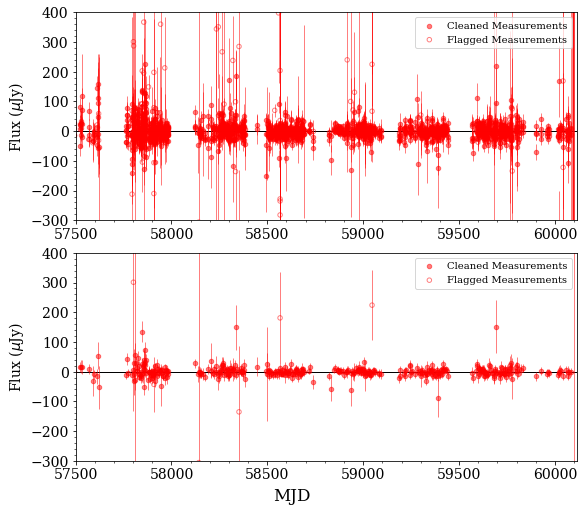

In [4]:
color = 'red'

og_lc = pdastrostatsclass()
og_lc.load(filename=source_dir+'/2023ixf.o.lc.txt')
#print(og_lc.t)

fig1, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
fig1.set_figwidth(8)
fig1.set_figheight(7)
fig1.supxlabel('MJD')

# og lc 

ax1.set_ylim(-300,400)
ax1.set_xlim(57500,discovery_date)
ax1.minorticks_on()
#ax1.get_xaxis().set_ticks([])
ax1.set_ylabel(r'Flux ($\mu$Jy)')
ax1.axhline(linewidth=1, color='k', zorder=0)

good_ix = og_lc.ix_unmasked('Mask',maskval=0x1|0x2|0x400000)
bad_ix = AnotB(og_lc.getindices(),good_ix)

# cleaned
ax1.errorbar(og_lc.t.loc[good_ix,'MJD'], og_lc.t.loc[good_ix,'uJy'], yerr=og_lc.t.loc[good_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax1.scatter(og_lc.t.loc[good_ix,'MJD'], og_lc.t.loc[good_ix,'uJy'], s=20, color=color, marker='o', alpha=0.5, label=f'Cleaned Measurements')

# flagged
ax1.errorbar(og_lc.t.loc[bad_ix,'MJD'], og_lc.t.loc[bad_ix,'uJy'], yerr=og_lc.t.loc[bad_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax1.scatter(og_lc.t.loc[bad_ix,'MJD'], og_lc.t.loc[bad_ix,'uJy'], s=20, facecolors='none', edgecolors=color, marker='o', alpha=0.5, label=f'Flagged Measurements')
ax1.legend(loc='upper right',fontsize=10)

# averaged lc

ax2.set_ylim(-300,400)
ax2.set_xlim(57500,discovery_date)
ax2.minorticks_on()
ax2.set_ylabel(r'Flux ($\mu$Jy)')
ax2.axhline(linewidth=1, color='k', zorder=0)

good_ix = lcs[0].ix_unmasked('Mask',maskval=flags)
bad_ix = AnotB(og_lc.getindices(),good_ix)

# cleaned
ax2.errorbar(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], yerr=lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax2.scatter(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], s=20, color=color, marker='o', alpha=0.5, label=f'Cleaned Measurements')

# flagged
ax2.errorbar(lcs[0].t.loc[bad_ix,'MJD'], lcs[0].t.loc[bad_ix,'uJy'], yerr=lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax2.scatter(lcs[0].t.loc[bad_ix,'MJD'], lcs[0].t.loc[bad_ix,'uJy'], s=20, facecolors='none', edgecolors=color, marker='o', alpha=0.5, label=f'Flagged Measurements')
ax2.legend(loc='upper right',fontsize=10)

# plot 1
pre-SN lc, 1 control lc

In [5]:
# select the control light curve to plot
select_index = 7

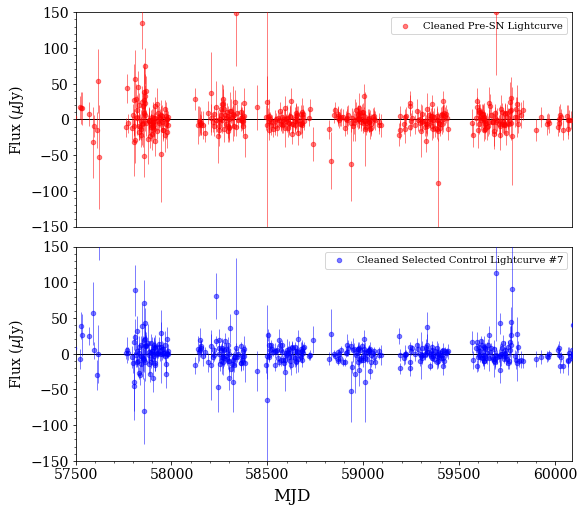

In [6]:
color = 'red'
ctrl_color = 'blue'

fig1, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
fig1.set_figwidth(8)
fig1.set_figheight(7)
fig1.supxlabel('MJD')

ax1.set_ylim(-150,150)
ax1.set_xlim(57500,60090)
ax1.minorticks_on()
ax1.get_xaxis().set_ticks([])
ax1.set_ylabel(r'Flux ($\mu$Jy)')
ax1.axhline(linewidth=1, color='k', zorder=0)

# pre-SN lc flux
good_ix = lcs[0].ix_unmasked('Mask',maskval=flags)
ax1.errorbar(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], yerr=lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5, zorder=20)
ax1.scatter(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], s=20, color=color, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Lightcurve', zorder=20)
ax1.legend(loc='upper right',fontsize=10)

ax2.set_ylim(-150,150)
ax2.set_xlim(57500,60090)
ax2.minorticks_on()
ax2.set_ylabel(r'Flux ($\mu$Jy)')
ax2.axhline(linewidth=1, color='k', zorder=0)

# control lc flux
good_ix = lcs[select_index].ix_unmasked('Mask',maskval=flags)
ax2.errorbar(lcs[select_index].t.loc[good_ix,'MJD'], lcs[select_index].t.loc[good_ix,'uJy'], yerr=lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=ctrl_color, elinewidth=1, c=ctrl_color, alpha=0.5, zorder=10)
ax2.scatter(lcs[select_index].t.loc[good_ix,'MJD'], lcs[select_index].t.loc[good_ix,'uJy'], s=20, color=ctrl_color, marker='o', alpha=0.5, label=f'Cleaned Selected Control Lightcurve #{select_index}', zorder=10)
ax2.legend(loc='upper right',fontsize=10)

# plot 2

In [7]:
# select the control light curve to add the simulated gaussian to
select_index = 7

# search for gaussian sigma for simulated gaussian
gauss_sigma = 128

# peak mjd for simulated gaussian
sim_peak_mjd = 58600

# gaussian sigma of simulated bump
sim_gauss_sigma = 128

# peak flux for simulated gaussian
sim_peak = 30

In [8]:
# apply weighted gaussian rolling sum to control lc
lcs[select_index] = apply_gaussian(lcs[select_index], gauss_sigma, print_=False)

# apply weighted gaussian rolling sum to pre-SN lc
lcs[0] = apply_gaussian(lcs[0], gauss_sigma, print_=False)

# add simulated gaussian and apply gaussian weighted rolling sum
simlc = copy.deepcopy(lcs[select_index])
sim_appmag = -2.5 * np.log10(sim_peak) + 23.9
simlc = apply_gaussian(simlc, gauss_sigma, sim_gauss=True, sim_peakmjd=sim_peak_mjd, sim_appmag=sim_appmag, sim_sigma=sim_gauss_sigma)

# Adding simulated gaussian: peak at MJD 58600.00; apparent magnitude 20.21; sigma- and sigma+ of 128.00 days
# Sigma: 128.00 days; MJD bin size: 1.00 days; sigma: 128.00 bins; window size: 768 bins


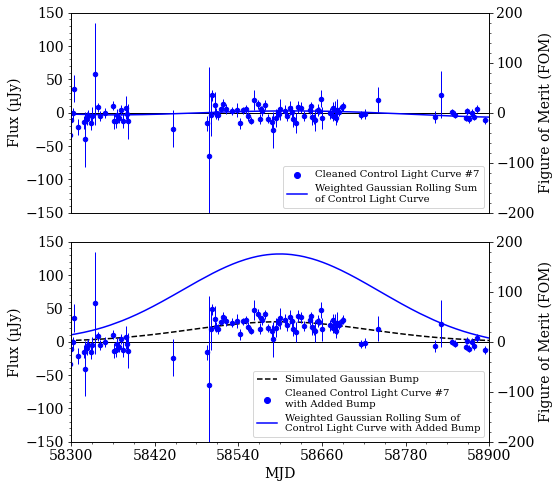

In [9]:
ctrl_color = 'blue'

fig2, (ax1, ax3) = plt.subplots(2, constrained_layout=True)
fig2.set_figwidth(8)
fig2.set_figheight(7)
#fig2.supxlabel('MJD')

# panel 1

ax1.set_ylabel(r'Flux (µJy)')
ax1.axhline(linewidth=1,color='k')
ax1.tick_params(axis='y')
ax1.get_xaxis().set_ticks([])
ax1.minorticks_on()
ax1.set_ylim(-150,150)
ax1.set_xlim(58300,58900)

# control lc flux
good_ix = lcs[select_index].ix_unmasked('Mask',maskval=flags)
ax1.errorbar(lcs[select_index].t.loc[good_ix,'MJD'], lcs[select_index].t.loc[good_ix,'uJy'], yerr=lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', elinewidth=1, c=ctrl_color, alpha=1, zorder=20)
ax1.scatter(lcs[select_index].t.loc[good_ix,'MJD'], lcs[select_index].t.loc[good_ix,'uJy'], s=20, color=ctrl_color, marker='o', alpha=1, zorder=20)

# control lc FOM
ax2 = ax1.twinx()
ax2.minorticks_on()
ax2.set_ylim(-200,200)
ax2.set_ylabel('Figure of Merit (FOM)')
ax2.scatter([0,1],[0,0], color=ctrl_color, alpha=1, marker='o', zorder=0, label=f'Cleaned Control Light Curve #{select_index}')
ax2.plot(lcs[select_index].t['MJDbin'], lcs[select_index].t['SNRsumnorm'], color=ctrl_color, alpha=1, label=f'Weighted Gaussian Rolling Sum \nof Control Light Curve')
plt.legend(loc='lower right', fontsize=10)
ax2.tick_params(axis='y')
#align_yaxis(ax1, ax2)

# panel 2

ax3.minorticks_on()
ax3.set_xlabel('MJD')
ax3.set_ylabel(r'Flux (µJy)')
ax3.axhline(linewidth=1,color='k')
ax3.set_ylim(-150,150)
ax3.set_xlim(58300,58900)
ax3.errorbar(simlc.t.loc[good_ix,'MJD'], simlc.t.loc[good_ix,'uJysim'], yerr=simlc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1, c=ctrl_color, alpha=1, zorder=10)
ax3.scatter(simlc.t.loc[good_ix,'MJD'], simlc.t.loc[good_ix,'uJysim'], s=20, color=ctrl_color, marker='o', alpha=1, zorder=10)

def my_gauss(x, sigma=sim_gauss_sigma, h=sim_peak, mid=sim_peak_mjd):
    variance = math.pow(sigma, 2)
    return h * math.exp(-math.pow(x-mid, 2)/(2*variance))
x = np.linspace(sim_peak_mjd - 3*sim_gauss_sigma, sim_peak_mjd + 3*sim_gauss_sigma, 100)
y = [my_gauss(xi) for xi in x]
ax3.plot(x, y, color='black', linestyle='dashed')

ax3.tick_params(axis='y')

import matplotlib.ticker as ticker
ax3.xaxis.set_major_locator(ticker.LinearLocator(6))
ax3.xaxis.set_minor_locator(ticker.LinearLocator(31))

ax4 = ax3.twinx()
ax4.minorticks_on()
ax4.set_ylim(-200,200)
ax4.set_ylabel('Figure of Merit (FOM)')
ax4.plot([0,1],[0,0], color='black', linestyle='dashed', alpha=1, label=f'Simulated Gaussian Bump')
ax4.scatter([0,1],[0,0], color=ctrl_color, alpha=1, marker='o', label=f'Cleaned Control Light Curve #{select_index} \nwith Added Bump')
ax4.plot(simlc.t['MJDbin'], simlc.t['SNRsimsum'], color=ctrl_color, alpha=1, label=f'Weighted Gaussian Rolling Sum of \nControl Light Curve with Added Bump')
ax4.tick_params(axis='y')
plt.legend(loc='lower right', fontsize=10)
#align_yaxis(ax3, ax4)

fig2.tight_layout()

# plot 3
rolling sum of pre-SN lc and all control lcs

In [10]:
# skip certain control lc indices
skip_ctr = [3]

# select the control light curve to highlight
select_index = 7

# select the gaussian sigma of the rolling gaussian weighted sum to be applied to all light curves
gauss_sigma = 11

# select detection limit to plot
detection_limit = 9.7

In [11]:
# apply rolling gaussian weighted sum to pre-SN and control light curves
for control_index in range(0, n_controls+1):
    if control_index in skip_ctr:
        continue
    lcs[control_index] = apply_gaussian(lcs[control_index], gauss_sigma, print_=False)

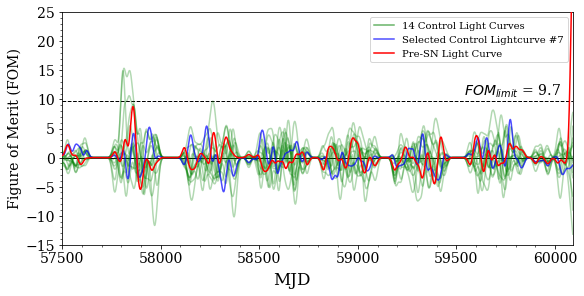

In [12]:
color = 'red'
ctrl_color = 'blue'
else_color = 'green'

fig, ax1 = plt.subplots(1, constrained_layout=True)
fig.set_figwidth(8)
fig.set_figheight(4)
fig.supxlabel('MJD')

ax1.set_xlim(57500,60090)
ax1.set_ylim(-15, 25)
ax1.minorticks_on()
ax1.set_ylabel('Figure of Merit (FOM)')
ax1.axhline(linewidth=1, color='k', zorder=0)

# control lcs flux
for control_index in range(1, n_controls):
    if control_index in skip_ctr or control_index == select_index:
        continue
    ax1.plot(lcs[control_index].t['MJDbin'], lcs[control_index].t['SNRsumnorm'], color=else_color, alpha=0.3, zorder=10)
ax1.plot([0,1],[0,0], color=else_color, alpha=0.6, zorder=0, label=f'{n_controls-len(skip_ctr)-1} Control Light Curves')

# selected control lc flux
ax1.plot(lcs[select_index].t['MJDbin'], lcs[select_index].t['SNRsumnorm'], color=ctrl_color, alpha=0.7, zorder=20, label=f'Selected Control Lightcurve #{select_index}')

# pre-SN lc flux
ax1.plot(lcs[0].t['MJDbin'], lcs[0].t['SNRsumnorm'], color=color, label='Pre-SN Light Curve', zorder=40)

ax1.axhline(detection_limit, linewidth=1, color='black', linestyle='dashed') 
ax1.text(59540, detection_limit+1, r'$FOM_{limit}$ = '+str(detection_limit), fontsize=14)

ax1.legend(loc='upper right',fontsize=10)

# plot 4

rolling sum of 3 simulated bumps

In [13]:
# select the control light curve to add simulated bumps to
select_index = 7

# select detection limit to plot
detection_limit = 9.7

# number of simulated bumps to add to the light curve
n_sim_gauss = 3 

# search for pre-SN bumps with gauss_sigmas gaussian sigmas in days
gauss_sigmas = [11, 11, 11]

# peak mjd for each simulated bumps
sim_peak_mjds = [57900, 58600, 59250]

# gaussian sigma in days of each simulated bump
sim_gauss_sigmas = [11, 11, 11]

# peak flux for each simulated bumps
sim_peaks = [10, 30, 60] 

In [14]:
# apply weighted gaussian rolling sum to control lc
lcs[select_index] = apply_gaussian(lcs[select_index], gauss_sigma, print_=False)

# Adding simulated gaussian: peak at MJD 57900.00; apparent magnitude 21.40; sigma- and sigma+ of 11.00 days
# Sigma: 11.00 days; MJD bin size: 1.00 days; sigma: 11.00 bins; window size: 66 bins
# Adding simulated gaussian: peak at MJD 58600.00; apparent magnitude 20.21; sigma- and sigma+ of 11.00 days
# Sigma: 11.00 days; MJD bin size: 1.00 days; sigma: 11.00 bins; window size: 66 bins
# Adding simulated gaussian: peak at MJD 59250.00; apparent magnitude 19.45; sigma- and sigma+ of 11.00 days
# Sigma: 11.00 days; MJD bin size: 1.00 days; sigma: 11.00 bins; window size: 66 bins


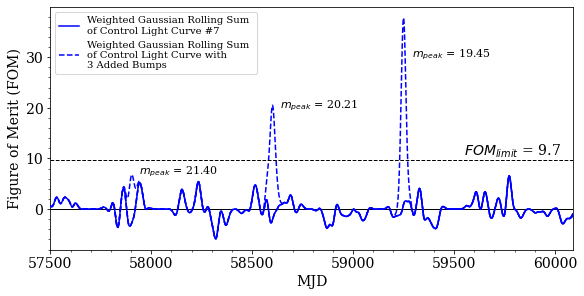

In [15]:
ctrl_color = 'blue'

# plot 2
fig4, ax1 = plt.subplots(1, constrained_layout=True)
fig4.set_figwidth(8)
fig4.set_figheight(4)

ax1.set_xlim(57500,60090)
ax1.minorticks_on()
ax1.set_ylabel('Figure of Merit (FOM)')
ax1.set_xlabel('MJD')
ax1.axhline(linewidth=1, color='k', zorder=0)
ax1.plot(lcs[select_index].t['MJDbin'], lcs[select_index].t['SNRsumnorm'], color=ctrl_color, alpha=1, zorder=10)

# add simulated gausssians to selected control light curve
y = [7,20,30]
for i in range(n_sim_gauss): # for each simulated gaussian
    # add that simulated gaussian and apply gaussian weighted rolling sum
    simlc = copy.deepcopy(lcs[select_index])
    sim_appmag = -2.5 * np.log10(sim_peaks[i]) + 23.9
    simlc = apply_gaussian(simlc, gauss_sigmas[i], sim_gauss=True, sim_peakmjd=sim_peak_mjds[i], sim_appmag=sim_appmag, sim_sigma=sim_gauss_sigmas[i])
    
    # plot it
    ax1.plot(simlc.t['MJDbin'], simlc.t['SNRsimsum'], linestyle='dashed', color=ctrl_color, zorder=0)
    ax1.text(sim_peak_mjds[i]+40, y[i], r'$m_{peak}$ = '+f'{sim_appmag:0.2f}', fontsize=11) #y=sim_peaks[i]

ax1.axhline(detection_limit, linewidth=1, color='black', linestyle='dashed') 
ax1.text(59550, detection_limit+1, r'$FOM_{limit}$ = '+str(detection_limit), fontsize=14)

ax1.plot([0,1],[0,0], color=ctrl_color, alpha=1, label='Weighted Gaussian Rolling Sum \nof Control Light Curve #7')
ax1.plot([0,1],[0,0], color=ctrl_color, linestyle='dashed', alpha=1, label=f'Weighted Gaussian Rolling Sum \nof Control Light Curve with\n{n_sim_gauss} Added Bumps')
plt.legend(loc='upper left',fontsize=10)

# plot 5

efficiencies

In [16]:
# select the gaussian sigma of the rolling gaussian weighted sum
gauss_sigma = 128

# enter the simulated peak fluxes
peaks =  [5.75, 7.7, 10.3, 13.77, 18.42, 24.64, 32.95, 44.08, 58.96, 78.86, 105.48, 141.08, 188.71, 252.41, 337.61, 451.58, 604.02, 807.92, 1080.65, 1445.44]

# upper panel parameters

# choose fixed detection limit
fixed_detection_limit = 10.8

# select possible simulated gaussian sigmas
sim_sigmas = [2, 5, 11, 24, 56, 128]

# lower panel parameters

# choose fixed input simulated gaussian sigma
fixed_sim_sigma = 128

# select different detection limits
detection_limits = [8, 10.8, 13]

In [17]:
# plot 1

# read in efficiency data 
detected_per_peak = load_detected_per_peak(source_dir)
detected = load_detected(source_dir, [gauss_sigma], peaks)

def get_dpp_coltitle(detection_limit, sim_sigma):
    return f'percent_detected_{detection_limit}_simsigma{sim_sigma:0.1f}'

# recalculate efficiency for each width range
gauss_sigma_ix = detected_per_peak.ix_equal(colnames=['gauss_sigma'], val=gauss_sigma)
for sim_sigma in sim_sigmas:
    # recalculate efficiency
    for i in gauss_sigma_ix:
        peak = detected_per_peak.t.loc[i,'peak_flux']
        gauss_sigma = detected_per_peak.t.loc[i,'gauss_sigma']
        
        detected_ix = detected[f'{gauss_sigma}_{peak:0.2f}'].ix_inrange(colnames=['max_SNRsimsum'], lowlim=fixed_detection_limit)
        sigma_ix = detected[f'{gauss_sigma}_{peak:0.2f}'].ix_equal(colnames=['sigma_days'], val=sim_sigma) #detected[f'{gauss_sigma}_{peak:0.2f}'].ix_inrange(colnames=['sigma_days'], lowlim=sim_sigma, uplim=width_range[1]/2)
        percent_detected = len(AandB(detected_ix, sigma_ix))/len(sigma_ix) * 100
        detected_per_peak.t.loc[i, get_dpp_coltitle(fixed_detection_limit, sim_sigma)] = percent_detected

# plot efficiencies

fig1, ax1 = plt.subplots(1, constrained_layout=True)
fig1.set_figwidth(8)
fig1.set_figheight(4)

# app mag
ax1.set_title(r'Efficiencies for $FOM_{limit}$ = '+str(fixed_detection_limit), pad=10)
ax1.axhline(linewidth=1,color='k')
ax1.set_ylabel('Efficiency (%)', fontsize=14)
for sim_sigma in sim_sigmas:
    label = "\N{greek small letter tau}" + r"$'_{G}$ = " + f'{sim_sigma} days'
    ax1.plot(detected_per_peak.t.loc[gauss_sigma_ix, 'peak_appmag'], 
             detected_per_peak.t.loc[gauss_sigma_ix, get_dpp_coltitle(fixed_detection_limit, sim_sigma)], label=label) #marker='o', 
ax1.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=10)
ax1.set_xlabel(r'$m_{peak}$ (app mag)')
ax1.set_xlim(16,22)

# abs mag
ax3 = ax1.twiny()
ax3.set_xticks(ax1.get_xticks() )
ax3.set_xbound(ax1.get_xbound())
ax3.set_xticklabels([round(x-29.04,2) for x in ax1.get_xticks()])
ax3.set_xlabel("$m_{peak}$ (abs mag)")

# plot 2

# recalculate efficiencies for each detection limit
gauss_sigma_ix = detected_per_peak.ix_equal(colnames=['gauss_sigma'], val=gauss_sigma)
for detection_limit in detection_limits:
    # recalculate efficiency
    for i in gauss_sigma_ix:
        peak = detected_per_peak.t.loc[i,'peak_flux']
        gauss_sigma = detected_per_peak.t.loc[i,'gauss_sigma']

        detected_ix = detected[f'{gauss_sigma}_{peak:0.2f}'].ix_inrange(colnames=['max_SNRsimsum'], lowlim=detection_limit)
        sigma_ix = detected[f'{gauss_sigma}_{peak:0.2f}'].ix_equal(colnames=['sigma_days'], val=fixed_sim_sigma) #detected[f'{gauss_sigma}_{peak:0.2f}'].ix_inrange(colnames=['sigma_days'], lowlim=fixed_sim_sigma[0]/2, uplim=width_range[1]/2)
        percent_detected = len(AandB(detected_ix, sigma_ix))/len(sigma_ix) * 100
        detected_per_peak.t.loc[i, get_dpp_coltitle(detection_limit, sim_sigma)] = percent_detected

# plot efficiencies

fig2, ax2 = plt.subplots(1, constrained_layout=True)
fig2.set_figwidth(8)
fig2.set_figheight(4)

# app mag
ax2.set_title(r'Efficiencies for ' + "\N{greek small letter tau}" + "$'_{G}$ = " + str(fixed_sim_sigma) + ' days', pad=10)
ax2.axhline(linewidth=1,color='k')
ax2.set_ylabel('Efficiency (%)', fontsize=14)
for detection_limit in detection_limits:
    label = r'$FOM_{limit}$ = ' + str(detection_limit)
    ax2.plot(detected_per_peak.t.loc[gauss_sigma_ix, 'peak_appmag'], 
             detected_per_peak.t.loc[gauss_sigma_ix, get_dpp_coltitle(detection_limit, sim_sigma)], label=label)
ax2.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=10)
ax2.set_xlabel(r'$m_{peak}$ (app mag)')
ax2.set_xlim(16,22)

# abs mag
ax4 = ax2.twiny()
ax4.set_xticks(ax1.get_xticks())
ax4.set_xbound(ax2.get_xbound())
ax4.set_xticklabels([round(x-29.04,2) for x in ax1.get_xticks()])
ax4.set_xlabel("$m_{peak}$ (abs mag)")

ERROR: could not read /Users/svoncoelln/Documents/swp/2023ixf/bump_analysis/tables2/detected_per_peak.txt!


RuntimeError: [Errno 2] No such file or directory: '/Users/svoncoelln/Documents/swp/2023ixf/bump_analysis/tables2/detected_per_peak.txt'

# plot 6

3 panels, one for each bump: 56742.8361, 57843.9334, 58781.3131

In [ ]:
bump_mjds = [57843.9334, 58781.3131]

# select detection limit to plot
detection_limit = 9.7

# select the gaussian sigma of the rolling gaussian weighted sum
gauss_sigma = 100

# plot x limits scale
scale = 200

In [ ]:
lcs[0] = apply_gaussian(lcs[0], gauss_sigma, print_=False)
good_ix = lcs[0].ix_unmasked('Mask',maskval=flags)

NameError: name 'bump_mjds' is not defined

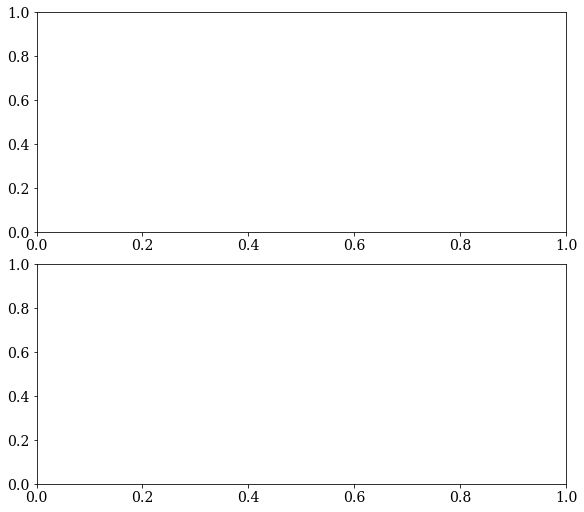

In [18]:
fig1, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
fig1.set_figwidth(8)
fig1.set_figheight(7)


# panel 1

bump_mjd = bump_mjds[0]
ax1.set_xlim(bump_mjd-scale, bump_mjd+scale)
ax1.set_ylim(-100,100)
ax1.set_ylabel(r'Flux (µJy)')
ax1.axhline(linewidth=1,color='k')
ax1.axhline(detection_limit, label='Detection Limit', linewidth=1, color='black', linestyle='dashed')
ax1.axvline(bump_mjd, label='Pre-SN Explosion', color='black')
ax1.tick_params(axis='y')
ax1.minorticks_on()

# flux
ax1.errorbar(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], yerr=lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax1.scatter(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], s=20, color=color, marker='o', alpha=1, label=f'Pre-SN Light Curve')

# FOM
ax1b = ax1.twinx()
ax1b.minorticks_on()
ax1b.set_ylim(-20,20)
ax1b.set_ylabel('Figure of Merit (FOM)')
ax1b.scatter([0,1],[0,0], color=color, alpha=1, marker='o', label=f'Pre-SN Light Curve')
ax1b.plot(lcs[0].t['MJDbin'], lcs[0].t['SNRsumnorm'], color=color, label='Weighted Gaussian Rolling Sum \nof Pre-SN Light Curve')

# panel 2

bump_mjd = bump_mjds[1]
ax2.set_xlabel('MJD')
ax2.set_xlim(bump_mjd-scale, bump_mjd+scale)
ax2.axhline(detection_limit, label='Detection Limit', linewidth=1, color='black', linestyle='dashed')
ax2.set_ylim(-100,100)
ax2.set_ylabel(r'Flux (µJy)')
ax2.axhline(linewidth=1,color='k')
ax2.axvline(bump_mjd, label='Pre-SN Explosion',  color='black')
ax2.tick_params(axis='y')
ax2.minorticks_on()

# flux
ax2.errorbar(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], yerr=lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color, alpha=0.5)
ax2.scatter(lcs[0].t.loc[good_ix,'MJD'], lcs[0].t.loc[good_ix,'uJy'], s=20, color=color, marker='o', alpha=1, label=f'Pre-SN Light Curve')

# FOM
ax2b = ax2.twinx()
ax2b.minorticks_on()
ax2b.set_ylim(-20,20)
ax2b.set_ylabel('Figure of Merit (FOM)')
ax2b.scatter([0,1],[0,0], color=color, alpha=1, marker='o', label=f'Pre-SN Light Curve')
ax2b.plot(lcs[0].t['MJDbin'], lcs[0].t['SNRsumnorm'], color=color, label='Weighted Gaussian Rolling Sum \nof Pre-SN Light Curve')

plt.legend(loc='upper left',  bbox_to_anchor=(1.15,1), fontsize=10)
